Unique values in 'class' column before cleaning:
 ['unknown' '2' '1']
Dataset shape after dropping NaN in 'class': (203768, 167)
Unique values in 'class' column after mapping:
 [2 0 1]
Class distribution after mapping:
 class
2    157204
0     42019
1      4545
Name: count, dtype: int64


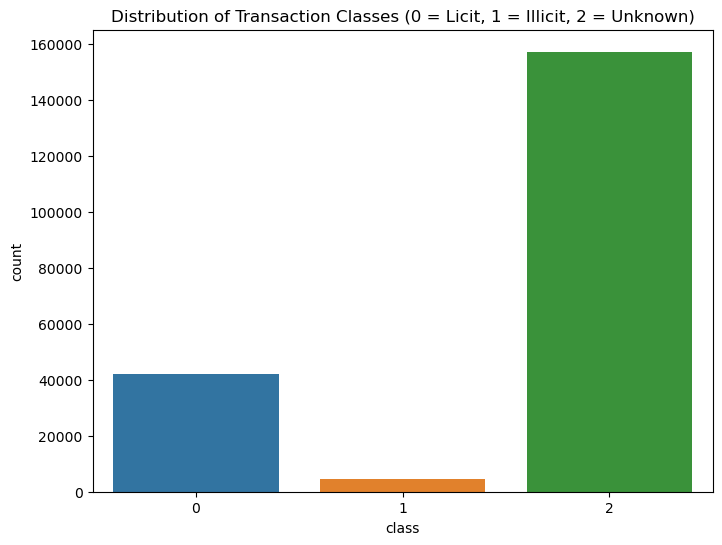

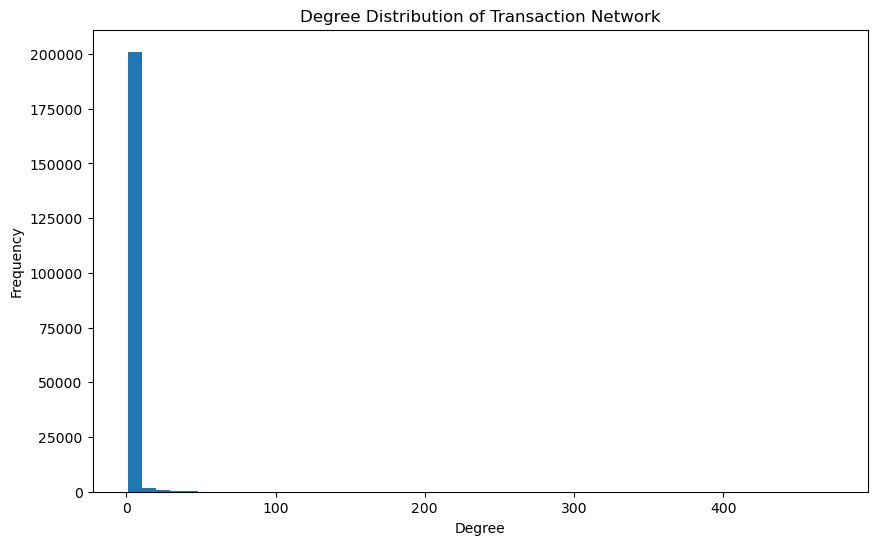

Dataset shape after excluding unknown transactions: (46564, 166)
Class distribution after excluding unknown (y):
 class
0    42019
1     4545
Name: count, dtype: int64


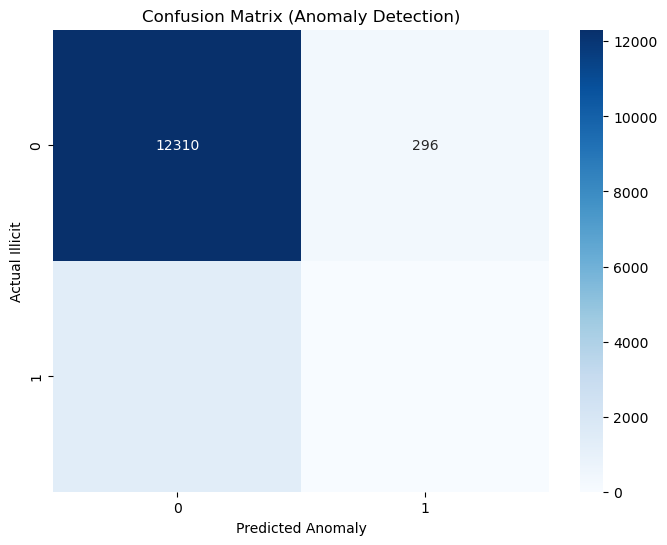

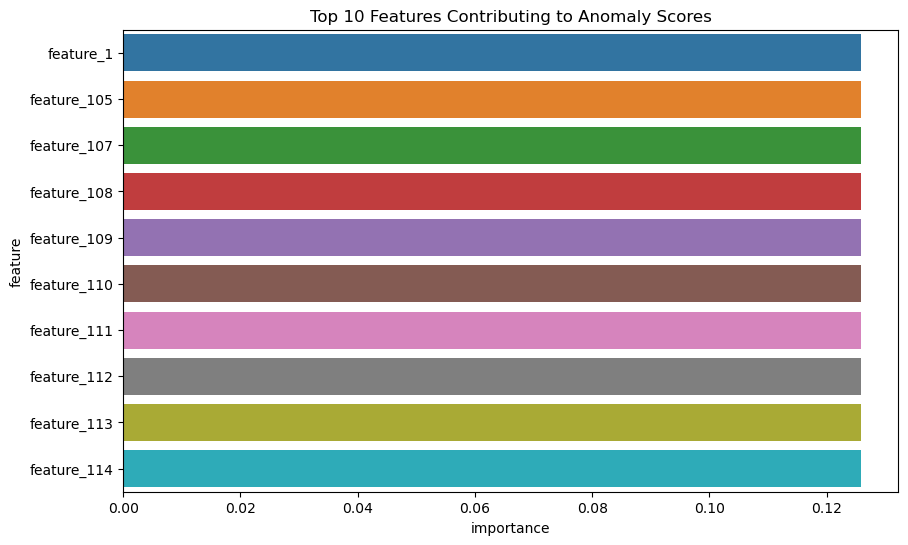

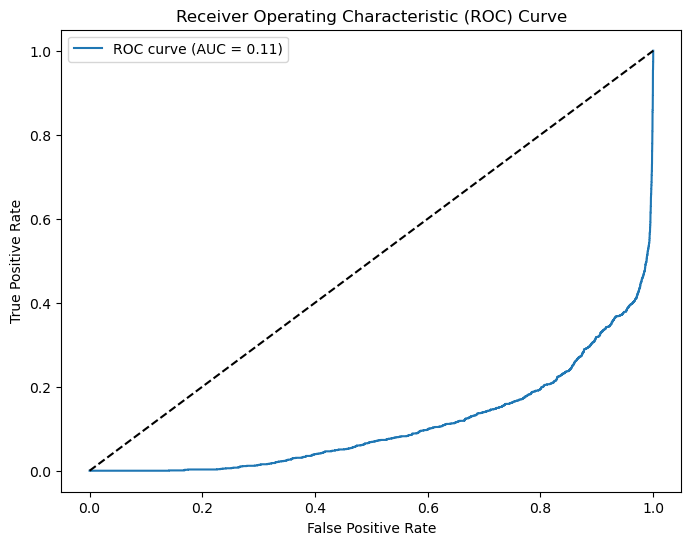

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



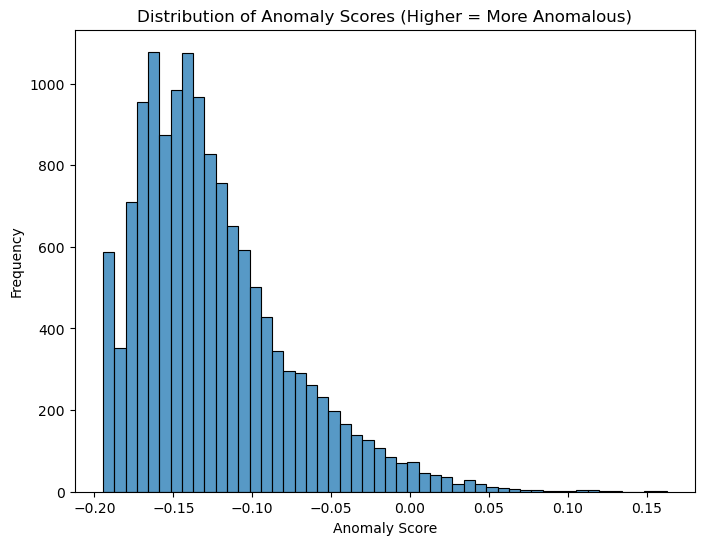

              precision    recall  f1-score   support

           0       0.90      0.98      0.94     12606
           1       0.00      0.00      0.00      1364

    accuracy                           0.88     13970
   macro avg       0.45      0.49      0.47     13970
weighted avg       0.81      0.88      0.85     13970



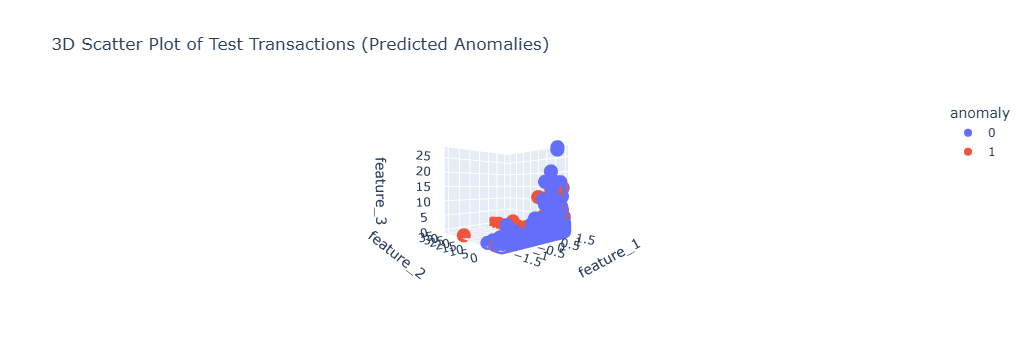

In [38]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import plotly.express as px


classes = pd.read_csv('elliptic_txs_classes.csv')
edgelist = pd.read_csv('elliptic_txs_edgelist.csv')
features = pd.read_csv('elliptic_txs_features.csv')

features.columns = ['txId'] + [f'feature_{i}' for i in range(1, len(features.columns))]
features = features.set_index('txId')
classes = classes.set_index('txId')

data = pd.merge(features, classes, left_index=True, right_index=True)

print("Unique values in 'class' column before cleaning:\n", data['class'].unique())


data['class'] = data['class'].astype(str).str.strip().str.lower()


data = data.dropna(subset=['class'])  
print("Dataset shape after dropping NaN in 'class':", data.shape)

class_mapping = {'2': 0, '1': 1, 'unknown': 2}
data['class'] = data['class'].map(class_mapping)

print("Unique values in 'class' column after mapping:\n", data['class'].unique())
print("Class distribution after mapping:\n", data['class'].value_counts())


data[features.columns] = data[features.columns].fillna(data[features.columns].mean())  


plt.figure(figsize=(8, 6))
sns.countplot(x='class', data=data)
plt.title('Distribution of Transaction Classes (0 = Licit, 1 = Illicit, 2 = Unknown)')
plt.show()


G = nx.from_pandas_edgelist(edgelist, 'txId1', 'txId2')

degrees = [d for n, d in G.degree()]
plt.figure(figsize=(10, 6))
plt.hist(degrees, bins=50)
plt.title('Degree Distribution of Transaction Network')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.show()

X = data.drop('class', axis=1)
y = data['class']

X = X[y != 2]
y = y[y != 2]
print("Dataset shape after excluding unknown transactions:", X.shape)
print("Class distribution after excluding unknown (y):\n", y.value_counts())

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, stratify=y, random_state=42)


iso_forest = IsolationForest(contamination=0.02, random_state=42)
iso_forest.fit(X_train)
y_pred = iso_forest.predict(X_test)
y_pred = np.where(y_pred == -1, 1, 0) 

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Anomaly Detection)')
plt.xlabel('Predicted Anomaly')
plt.ylabel('Actual Illicit')
plt.show()

feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': np.abs(iso_forest.decision_function(X_test)).mean()
})
feature_importance = feature_importance.sort_values('importance', ascending=False)


plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(10))
plt.title('Top 10 Features Contributing to Anomaly Scores')
plt.show()


y_scores = -iso_forest.decision_function(X_test)  
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
sns.histplot(-iso_forest.decision_function(X_test), bins=50)
plt.title('Distribution of Anomaly Scores (Higher = More Anomalous)')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.show()

print(classification_report(y_test, y_pred))

X_test_df = pd.DataFrame(X_test, columns=X.columns, index=y_test.index)
X_test_df['anomaly'] = y_pred.astype(str)
fig = px.scatter_3d(X_test_df.reset_index(), 
                    x=X.columns[0], 
                    y=X.columns[1], 
                    z=X.columns[2],
                    color='anomaly',
                    title='3D Scatter Plot of Test Transactions (Predicted Anomalies)')
fig.show()